# Introduction


# Introduction
There are multiple reasons for analyzing a version control system like your Git repository. See for example Adam Tornhill's book ["Your Code as a Crime Scene"](https://pragprog.com/book/atcrime/your-code-as-a-crime-scene) or his upcoming book ["Software Design X-Rays"](http://www.adamtornhill.com/swevolution/reviewersprogress.html) for plenty of inspirations:

You can 
- analyze knowledge islands
- distinguish often changing code from stable code parts
- identify code that is temporal coupled

Having the necessary data for those analyses in a Pandas <tt>DataFrame</tt> gives you many many possibilities to quickly gain insights about the evolution of your software system.

# The idea

In another [blog post](https://www.feststelltaste.de/reading-a-git-log-file-output-with-pandas/) I showed you a way to read in Git log data with [Pandas](http://pandas.pydata.org/)'s DataFrame and [GitPython](https://gitpython.readthedocs.io/en/stable/). Looking back, this was really complicated and tedious. So with a few tricks we can do it much more better this time:

- We use GitPython's feature to directly access an underlying Git installation. This is way more faster than using GitPython's object representation of the repository makes it possible to have everything we need in one notebook.
- We use in-memory reading by using StringIO to avoid unnecessary file access. This avoids storing the Git output on disk and read it from from disc again. This method is way more faster.
- We also exploit Pandas's <tt>read_csv</tt> method even more.  This makes the transformation of the Git log into a <tt>DataFrame</tt> as easy as pie.

# Reading the Git log
The first step is to connect GitPython with the Git repo. If we have an instance of the repo, we can gain access to the underlying Git installation of the operation system via <tt>repo.git</tt>.

In this case, again, we tap the Spring Pet Clinic project, a small sample application for the Spring framework.

In [23]:
import git 

GIT_REPO_PATH = r'../../spring-petclinic/'
repo = git.Repo(GIT_REPO_PATH)
git_bin = repo.git
git_bin

With the <tt>git_bin</tt>, we can execute almost any Git command we like directly. In our hypothetical use case, we want to retrieve some information about the change frequency of files. For this, we need the complete history of the Git repo including statistics for the changed files (via <tt>--numstat</tt>).

We use a little trick to make sure, that the format for the file's statistics fits nicely with the commit's metadata (SHA <tt>%h</tt>, UNIX timestamp <tt>%at</tt> and author's name <tt>%aN</tt>). The <tt>--numstat</tt> option provides data for additions, deletions and the affected file name in one line, separated by the tabulator character <tt>\t</tt>:  
<p>
<tt>1<b>\t</b>1<b>\t</b>some/file/name.ext</tt>
</p>

We use the same tabular separator <tt>\t</tt> for the format string:
<p>
<tt>%h<b>\t</b>%at<b>\t</b>%aN</tt>
</p>

And here is the trick: Additionally, we add the amount of tabulators of the file's statistics plus an additional tabulator in front of the format string to pretend that there are empty file statistics' information in front of the format string.

The results looks like this:

<p>
<tt>\t\t\t%h\t%at\t%aN</tt>
</p>

Note: If you want to export the Git log on the command line into a file to read that file later, you need to use the tabulator character xxx as separator instead of <tt>\t</tt> in the format string. Otherwise, the trick doesn't work.


OK, let's first executed the Git log export:

In [39]:
git_log = git_bin.execute('git log --numstat --pretty=format:"\t\t\t%h\t%at\t%aN"')
git_log[:80]

'\t\t\t101c9dc\t1498817227\tDave Syer\n2\t3\tpom.xml\n\n\t\t\tffa967c\t1492026060\tAntoine Rey\n1'

We now read in the complete files' history in the <tt>git_log</tt> variable. Don't let confuse you by all the <tt>\t</tt> characters. 

Let's read the result into a Pandas <tt>DataFrame</tt> by using the <tt>read_csv</tt> method. Because we can't provide a file path to a CSV data, we have to use StringIO to read in our in-memory buffered content.

Pandas will read the first line of the tabular-separated "file", sees the many tabular-separated columns and parses all other lines in the same format / column layout. Additionaly, we set the <tt>header</tt> to <tt>None</tt> because we don't have one and provide nice names for all the columns that we read in.

In [6]:
import pandas as pd
from io import StringIO

commits_raw = pd.read_csv(StringIO(git_log), 
    sep="\t",
    header=None,              
    names=['additions', 'deletions', 'filename', 'sha', 'timestamp', 'author']
    )
commits_raw.head()

,additions,deletions,filename,sha,timestamp,author
0,NaN,NaN,NaN,101c9dc,1.498817e+09,Dave Syer
1,2,3,pom.xml,NaN,NaN,NaN
2,NaN,NaN,NaN,ffa967c,1.492026e+09,Antoine Rey
3,1,1,readme.md,NaN,NaN,NaN
4,NaN,NaN,NaN,fd1c742,1.488785e+09,Antoine Rey


We got two different kind of content for the rows:


For each other row, we got some statistics about the modified files:
<pre>
2	0	src/main/asciidoc/appendices/bibliography.adoc
</pre>

It contains the number of lines inserted, the number of lines deleted and the relative path of the file. With a little trick and a little bit of data wrangling, we can read that information into a nicely structured DataFrame.

The last steps are easy. We fill all the empty file statistics rows with the commit's metadata.

In [7]:
commits = commits_raw.fillna(method='ffill')
commits.head()

,additions,deletions,filename,sha,timestamp,author
0,NaN,NaN,NaN,101c9dc,1.498817e+09,Dave Syer
1,2,3,pom.xml,101c9dc,1.498817e+09,Dave Syer
2,2,3,pom.xml,ffa967c,1.492026e+09,Antoine Rey
3,1,1,readme.md,ffa967c,1.492026e+09,Antoine Rey
4,1,1,readme.md,fd1c742,1.488785e+09,Antoine Rey


And drop all the commit metadata rows that don't contain file statitics.

In [8]:
commits = commits.dropna()
commits.head()

,additions,deletions,filename,sha,timestamp,author
1,2,3,pom.xml,101c9dc,1.498817e+09,Dave Syer
2,2,3,pom.xml,ffa967c,1.492026e+09,Antoine Rey
3,1,1,readme.md,ffa967c,1.492026e+09,Antoine Rey
4,1,1,readme.md,fd1c742,1.488785e+09,Antoine Rey
5,1,0,pom.xml,fd1c742,1.488785e+09,Antoine Rey


We are finished! This is it. 

In summary, you'll need "one-liner" for converting a Git log file output that was exported with
```
git log --numstat --pretty=format:"%x09%x09%x09%h%x09%at%x09%aN" > git.log
```
into a <tt>DataFrame</tt>:

In [21]:
pd.read_csv("../../spring-petclinic/git.log", 
            sep="\t", 
            header=None,
            names=[
               'additions', 
               'deletions', 
               'filename', 
               'sha', 
               'timestamp', 
               'author']).fillna(method='ffill').dropna().head()

,additions,deletions,filename,sha,timestamp,author
1,2,3,pom.xml,101c9dc,1.498817e+09,Dave Syer
2,2,3,pom.xml,ffa967c,1.492026e+09,Antoine Rey
3,1,1,readme.md,ffa967c,1.492026e+09,Antoine Rey
4,1,1,readme.md,fd1c742,1.488785e+09,Antoine Rey
5,1,0,pom.xml,fd1c742,1.488785e+09,Antoine Rey


# Bonus section
We can now convert some columns to their correct data types. The columns <tt>additions</tt> and <tt>deletions</tt> columns are representing the added or deleted lines of code respectively. But there are also a few exceptions for binary files like images. We skip these lines with the <tt>errors='coerce'</tt> option. This will lead to <tt>Nan</tt> in the rows that will be dropped after the conversion. 

The <tt>timestamp</tt> column is a UNIX timestamp with the past seconds since January 1st 1970 we can easily convert with Pandas' <tt>to_datetime</tt> method.

In [ ]:
commits['additions'] = pd.to_numeric(commits['additions'], errors='coerce')
commits['deletions'] = pd.to_numeric(commits['deletions'], errors='coerce')
commits = commits.dropna()
commits['timestamp'] = pd.to_datetime(commits['timestamp'], unit="s")
commits.head()

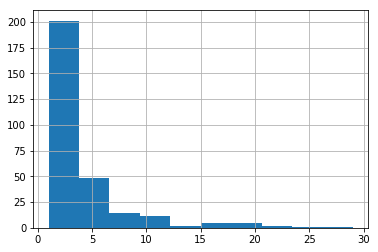

In [54]:
%matplotlib inline
commits[commits['filename'].str.endswith(".java")]\
    .groupby('filename')\
    .count()['additions']\
    .hist()

# Summary
In this notebook, I showed you how to read some a Git log output with another separator trick in only one line. This is a very handy method and a good base for further analysis! 